In [1]:
# 03-hyperparameter-tuning.ipynb
# Customer Lifetime Value Prediction - Hyperparameter Tuning
# Using Vertex AI Vizier for Bayesian optimization

# Imports
import pandas as pd
import numpy as np
from google.cloud import aiplatform
from google.cloud import storage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Configuration
PROJECT_ID = "clv-predictions-mlops"
REGION = "us-central1"
BUCKET_NAME = "clv-prediction-data"

# Initialize Vertex AI
aiplatform.init(project=PROJECT_ID, location=REGION)

# Load features from GCS
!gsutil cp gs://{BUCKET_NAME}/features/clv_features.parquet /tmp/clv_features.parquet
df = pd.read_parquet('/tmp/clv_features.parquet')

# Prepare data
feature_cols = [c for c in df.columns if c not in ['customer_id', 'target_clv']]
X = df[feature_cols]
y = df['target_clv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data loaded: {X_train.shape[0]} train, {X_test.shape[0]} test")
print(f"Baseline from notebook 02: MAE=$1,987, R²=0.104")

2025-12-11 16:38:53.626177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Copying gs://clv-prediction-data/features/clv_features.parquet...
/ [1 files][  9.1 MiB/  9.1 MiB]                                                
Operation completed over 1 objects/9.1 MiB.                                      
Data loaded: 3412 train, 854 test
Baseline from notebook 02: MAE=$1,987, R²=0.104


In [2]:
# Define the model-building function with hyperparameters
def build_model(hp_units_1, hp_units_2, hp_dropout, hp_learning_rate):
    """Build model with given hyperparameters"""
    model = keras.Sequential([
        layers.Input(shape=(396,)),
        layers.Dense(hp_units_1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(hp_dropout),
        layers.Dense(hp_units_2, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.Dropout(hp_dropout * 0.7),  # Slightly less dropout in later layers
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model

def train_and_evaluate(hp_units_1, hp_units_2, hp_dropout, hp_learning_rate):
    """Train model and return MAE on validation set"""
    model = build_model(hp_units_1, hp_units_2, hp_dropout, hp_learning_rate)
    
    model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
        ],
        verbose=0
    )
    
    y_pred = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = np.clip(y_pred, 0, None)
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae, model

print("Training function defined")
print("\nHyperparameters to tune:")
print("  - hp_units_1: neurons in first layer (64-256)")
print("  - hp_units_2: neurons in second layer (32-128)")
print("  - hp_dropout: dropout rate (0.2-0.5)")
print("  - hp_learning_rate: learning rate (0.0001-0.01)")

Training function defined

Hyperparameters to tune:
  - hp_units_1: neurons in first layer (64-256)
  - hp_units_2: neurons in second layer (32-128)
  - hp_dropout: dropout rate (0.2-0.5)
  - hp_learning_rate: learning rate (0.0001-0.01)


In [8]:
!pip install google-vizier -q

In [11]:
from google.cloud.aiplatform import vizier
print("Vizier imported successfully")
print(dir(vizier))
# Check available algorithm options
print("Available algorithms:", [a for a in dir(vz.Algorithm) if not a.startswith('_')])

Vizier imported successfully
['Study', 'Trial', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'client_abc', 'pyvizier', 'study', 'trial']
Available algorithms: ['ALGORITHM_UNSPECIFIED', 'GRID_SEARCH', 'RANDOM_SEARCH']


In [13]:
from google.cloud.aiplatform.vizier import Study
from google.cloud.aiplatform.vizier import pyvizier as vz

# Define study config
study_config = vz.StudyConfig()
study_config.algorithm = vz.Algorithm.RANDOM_SEARCH

# Metric to optimize
study_config.metric_information.append(
    vz.MetricInformation(name="mae", goal=vz.ObjectiveMetricGoal.MINIMIZE)
)

# Hyperparameters to tune
study_config.search_space.root.add_int_param("units_1", 64, 256)
study_config.search_space.root.add_int_param("units_2", 32, 128)
study_config.search_space.root.add_float_param("dropout", 0.2, 0.5)
study_config.search_space.root.add_float_param("learning_rate", 0.0001, 0.01, scale_type=vz.ScaleType.LOG)

# Create study
study = Study.create_or_load(
    display_name="clv_hyperparameter_study",
    problem=study_config,
    project=PROJECT_ID,
    location=REGION
)

print(f"Created study: {study.name}")
print(f"\nSearch space:")
print(f"  units_1: 64-256 (int)")
print(f"  units_2: 32-128 (int)")
print(f"  dropout: 0.2-0.5 (float)")
print(f"  learning_rate: 0.0001-0.01 (log scale)")

Created study: 1368594300354

Search space:
  units_1: 64-256 (int)
  units_2: 32-128 (int)
  dropout: 0.2-0.5 (float)
  learning_rate: 0.0001-0.01 (log scale)


In [15]:
# Run hyperparameter tuning trials
N_TRIALS = 15
best_mae = float('inf')
best_model = None
best_params = None
all_results = []

print(f"Running {N_TRIALS} Vizier trials...\n")
print("="*60)

for i in range(N_TRIALS):
    # Get suggestion from Vizier
    suggestions = study.suggest(count=1)
    
    if not suggestions:
        print("No more suggestions available")
        break
    
    trial = suggestions[0]
    params = trial.parameters
    
    # Extract hyperparameters (get .value from ParameterValue)
    units_1 = int(params['units_1'].value)
    units_2 = int(params['units_2'].value)
    dropout = float(params['dropout'].value)
    learning_rate = float(params['learning_rate'].value)
    
    print(f"Trial {i+1}/{N_TRIALS}")
    print(f"  units_1={units_1}, units_2={units_2}, dropout={dropout:.2f}, lr={learning_rate:.5f}")
    
    # Train and evaluate
    mae, model = train_and_evaluate(units_1, units_2, dropout, learning_rate)
    
    # Report result back to Vizier
    trial.complete(measurement=vz.Measurement(metrics={'mae': mae}))
    
    all_results.append({
        'trial': i+1,
        'units_1': units_1,
        'units_2': units_2,
        'dropout': dropout,
        'learning_rate': learning_rate,
        'mae': mae
    })
    
    print(f"  → MAE: ${mae:,.0f}")
    
    if mae < best_mae:
        best_mae = mae
        best_model = model
        best_params = {
            'units_1': units_1,
            'units_2': units_2,
            'dropout': dropout,
            'learning_rate': learning_rate
        }
        print(f"  ★ New best!")
    print()

print("="*60)
print(f"\nBest result:")
print(f"  MAE: ${best_mae:,.0f}")
print(f"  Params: {best_params}")
print(f"\nBaseline was: $1,987")

Running 15 Vizier trials...

Suggest Study study backing LRO: projects/674754622820/locations/us-central1/studies/1368594300354/operations/1368594300354__1
<class 'google.cloud.aiplatform_v1.services.vizier_service.client.VizierServiceClient'>
Study study suggested. Resource name: projects/674754622820/locations/us-central1/studies/1368594300354
Trial 1/15
  units_1=83, units_2=32, dropout=0.20, lr=0.00033


2025-12-11 17:07:26.596782: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  → MAE: $2,094
  ★ New best!

Suggest Study study backing LRO: projects/674754622820/locations/us-central1/studies/1368594300354/operations/1368594300354__2
<class 'google.cloud.aiplatform_v1.services.vizier_service.client.VizierServiceClient'>
Study study suggested. Resource name: projects/674754622820/locations/us-central1/studies/1368594300354
Trial 2/15
  units_1=201, units_2=74, dropout=0.25, lr=0.00272
  → MAE: $1,449
  ★ New best!

Suggest Study study backing LRO: projects/674754622820/locations/us-central1/studies/1368594300354/operations/1368594300354__3
<class 'google.cloud.aiplatform_v1.services.vizier_service.client.VizierServiceClient'>
Study study suggested. Resource name: projects/674754622820/locations/us-central1/studies/1368594300354
Trial 3/15
  units_1=150, units_2=62, dropout=0.33, lr=0.00019
  → MAE: $2,123

Suggest Study study backing LRO: projects/674754622820/locations/us-central1/studies/1368594300354/operations/1368594300354__4
<class 'google.cloud.aiplatfor

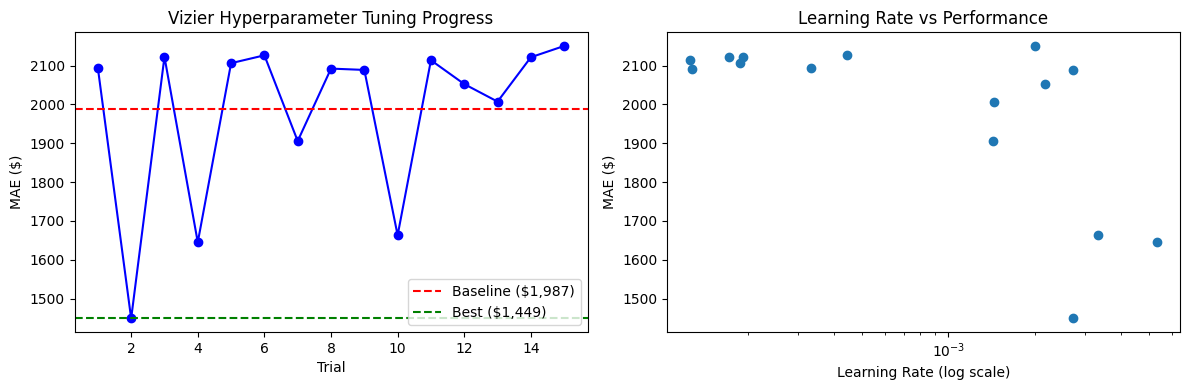

Saved: vizier_tuning.png


In [17]:
import matplotlib.pyplot as plt

# Visualize tuning results
results_df = pd.DataFrame(all_results)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# MAE over trials
axes[0].plot(results_df['trial'], results_df['mae'], 'bo-')
axes[0].axhline(y=1987, color='r', linestyle='--', label='Baseline ($1,987)')
axes[0].axhline(y=best_mae, color='g', linestyle='--', label=f'Best (${best_mae:,.0f})')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('MAE ($)')
axes[0].set_title('Vizier Hyperparameter Tuning Progress')
axes[0].legend()

# Hyperparameter vs MAE (learning rate)
axes[1].scatter(results_df['learning_rate'], results_df['mae'])
axes[1].set_xscale('log')
axes[1].set_xlabel('Learning Rate (log scale)')
axes[1].set_ylabel('MAE ($)')
axes[1].set_title('Learning Rate vs Performance')

plt.tight_layout()
plt.savefig('vizier_tuning.png', dpi=150)
plt.show()

print("Saved: vizier_tuning.png")

In [18]:
# Save the best tuned model
best_model.export('clv_model_tuned')
best_model.save('clv_model_tuned.keras')

# Upload to GCS
!gsutil -m cp -r clv_model_tuned gs://{BUCKET_NAME}/models/
!gsutil cp clv_model_tuned.keras gs://{BUCKET_NAME}/models/

# Save tuning results
results_df.to_csv('tuning_results.csv', index=False)
!gsutil cp tuning_results.csv gs://{BUCKET_NAME}/models/

print("\nNotebook 03 Complete!")
print("="*50)
print(f"Baseline MAE:  $1,987")
print(f"Tuned MAE:     ${best_mae:,.0f}")
print(f"Improvement:   {((1987-best_mae)/1987)*100:.1f}%")
print(f"\nBest hyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
print(f"\nArtifacts saved to GCS:")
print(f"  gs://{BUCKET_NAME}/models/clv_model_tuned/")
print(f"  gs://{BUCKET_NAME}/models/clv_model_tuned.keras")
print(f"\nNext: 04-pipeline-orchestration.ipynb (Vertex AI Pipelines)")

INFO:tensorflow:Assets written to: clv_model_tuned/assets


INFO:tensorflow:Assets written to: clv_model_tuned/assets


Saved artifact at 'clv_model_tuned'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 396), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140393660779152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140393660789712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140393093641168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140393093639408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140393093635536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140393093631664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140393093642048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140393093639936: TensorSpec(shape=(), dtype=tf.resource, name=None)
Copying file://clv_model_tuned/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://clv_model_tuned/saved_model.pb [Content-Type=application/oc